In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#Import data for processing

filename = "./20-08-2020/SMC_4rose_3.xlsx"
data = pd.read_excel(filename, 
                    names = ["globaltime","dt",'rb1x','rb1y','rb1z','rb2x','rb2y','rb2z',
                            'rb3x','rb3y','rb3z','rb4x','rb4y','rb4z','rb5x','rb5y','rb5z',
                            'rb6x','rb6y','rb6z','rb7x','rb7y','rb7z','rb8x','rb8y','rb8z',
                            'xd','yd','thetad'])
while data.iloc[0]['rb1z']==0.0:    
    data = data.drop(0)
    data.index-=1
      
data.iloc[0]['rb1z']        


102.682970896644

In [3]:
#calculate robot position at each point

#calculate the center of the robot
Adet = (data['rb1x']*(data['rb4y']-data['rb6y']) -
       data['rb1y']*(data['rb4x']-data['rb6x']) +
       data['rb4x']*data['rb6y']-data['rb6x']*data['rb4y'])

Bdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb6y']-data['rb4y'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb1y']-data['rb6y'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb4y']-data['rb1y']) )

Cdet = ((data['rb1x']**2+data['rb1y']**2)*(data['rb4x']-data['rb6x'])  +
       (data['rb4x']**2+data['rb4y']**2)*(data['rb6x']-data['rb1x'])  +
       (data['rb6x']**2+data['rb6y']**2)*(data['rb1x']-data['rb4x']) )

x_r = -Bdet/(2.*Adet)/1000.+Bdet[0]/(2.*Adet[0])/1000. #robot global position x in meters (adjusted to origin)
y_r = -Cdet/(2.*Adet)/1000.+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters


x_mid = (data['rb1x']+data['rb8x'])/2./1000.+Bdet[0]/(2.*Adet[0])/1000. #calculate the midpoint of wheel 1 (adjusted to origin)
y_mid = (data['rb1y']+data['rb8y'])/2./1000.+Cdet[0]/(2.*Adet[0])/1000.

#rotate desired position to be in line with robot
#xd_rot =data['xd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-data['yd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
#yd_rot =data['yd']*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+data['xd']*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
xd_rot = data['xd']
yd_rot = data['yd']


xr_rot =x_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))+y_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))
yr_rot =y_r*np.cos(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))-x_r*np.sin(np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]))


#set robot initial position to the origin
#x_r = x_r+Bdet[0]/(2.*Adet[0])/1000. #robot position x in meters starting at origin
#y_r = y_r+Cdet[0]/(2.*Adet[0])/1000. #robot global position y in meters  starting at origin
theta_r = np.arctan2(y_mid-y_r,x_mid-x_r) - np.arctan2(y_mid[0]-y_r[0],x_mid[0]-x_r[0]) #robot angle starting at 0

In [57]:
#cast robot info into a new dataframe

pdata = pd.DataFrame()
pdata.insert(0,"globaltime", data['globaltime'],True) #get global time
pdata.insert(1, "x_r", xr_rot,True) #get robot positions (adjusted to origin)
pdata.insert(2, "y_r", yr_rot,True)
pdata.insert(3, "theta_r", theta_r,True)

pdata.insert(4, "x_d", xd_rot,True) #get robot desired positions (adjusted for starting orientation)
pdata.insert(5, "y_d", yd_rot,True)
pdata.insert(6, "theta_d", data['thetad'],True)

pdata.insert(7,'e_x', pdata['x_r']-pdata['x_d']) #calculate the errors at each point
pdata.insert(8,'e_y', pdata['y_r']-pdata['y_d'])
pdata.insert(9,'e_theta', pdata['theta_r']-pdata['theta_d'])

pdata.insert(10,'e_x_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(11,'e_y_nt',np.zeros(len(pdata['x_r'])))
pdata.insert(12,'e_theta_nt',np.zeros(len(pdata['x_r'])))

#for i in range (1000,len(pdata['theta_r'])): #use to drop the last x amount of data
#    pdata = pdata.drop(i)

#for i in range(0, 200):
#    pdata = pdata.drop(i)

In [ ]:
Chopnum=100
Min_index = 0

for i in range(Chopnum, len(pdata['x_r'])-Chopnum-1): #Minimize total RMSE
    print(i)
    temp = ((pdata.at[i,'x_r']-pdata[i-Chopnum:i+Chopnum]['x_d'])**2 
               + (pdata.at[i,'y_r']-pdata[i-Chopnum:i+Chopnum]['y_d'])**2 
               + (pdata.at[i,'theta_r']-pdata[i-Chopnum:i+Chopnum]['theta_d'])**2)
    Min_index= np.argmin(temp)
    
    pdata.iat[i,10] = (pdata.iat[i,1]-pdata.iat[Min_index,4])
    pdata.iat[i,11] = (pdata.iat[i,2]-pdata.iat[Min_index,5])
    pdata.iat[i,12] = (pdata.iat[i,3]-pdata.iat[Min_index,6])
    

for i in range (len(pdata['theta_r'])-Chopnum,len(pdata['theta_r'])): #cut off the useless data (start and end)
    pdata = pdata.drop(i)
for i in range(0, Chopnum):
    pdata = pdata.drop(i) 

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187


C:\Users\jdiro\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
290
291
292
293
294
295
296
297
298
299
300
301
302
303
304
305
306
307
308
309
310
311
312
313
314
315
316
317
318
319
320
321
322
323
324
325
326
327
328
329
330
331
332
333
334
335
336
337
338
339
340
341
342
343
344
345
346
347
348
349
350
351
352
353
354
355
356
357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437


2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113
2114
2115
2116
2117
2118
2119
2120
2121
2122
2123
2124
2125
2126
2127
2128
2129
2130
2131
2132
2133
2134
2135
2136
2137
2138
2139
2140
2141
2142
2143
2144
2145
2146
2147
2148
2149
2150
2151
2152
2153
2154
2155
2156
2157
2158
2159
2160
2161
2162
2163
2164
2165
2166
2167
2168
2169
2170
2171
2172
2173
2174
2175
2176
2177
2178
2179
2180
2181
2182
2183
2184
2185
2186
2187
2188
2189
2190
2191
2192
2193
2194
2195
2196
2197
2198
2199
2200
2201
2202
2203
2204
2205
2206
2207
2208
2209
2210
2211
2212
2213
2214
2215
2216
2217
2218
2219
2220


3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885


In [52]:
RMSE_x = np.sqrt(sum(pdata['e_x']**2)/len(pdata['e_x']))
RMSE_y = np.sqrt(sum(pdata['e_y']**2)/len(pdata['e_y']))
RMSE_theta = np.sqrt(sum(pdata['e_theta']**2)/len(pdata['e_theta']))

RMSE_x_nt = np.sqrt(sum(pdata['e_x_nt']**2)/len(pdata['e_x']))
RMSE_y_nt = np.sqrt(sum(pdata['e_y_nt']**2)/len(pdata['e_y']))
RMSE_theta_nt = np.sqrt(sum(pdata['e_theta_nt']**2)/len(pdata['e_theta']))

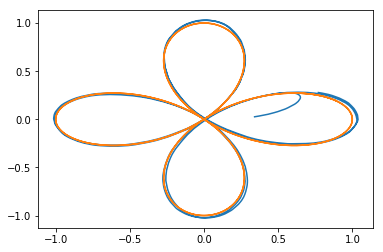

In [53]:
ax = plt.subplot(1,1,1)
#pdata['x_d'][0] = 0
ax.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#ax.plot(pdata.iloc[0]['x_d'],pdata.iloc[0]['y_d'],linewidth=6)
#print(pdata.iloc[0]['x_d'])
#print(pdata.iloc[0]['y_d'])
#print(np.arctan2(y_mid[0],x_mid[0])*180/np.pi)
#plt.plot(pdata['x_r'],pdata['y_r'],pdata['x_d'],pdata['y_d'])
#plt.plot(pdata[0]['x_d'],pdata[0]['y_d'])
plt.show()

In [54]:
print(RMSE_x)
print(RMSE_y)
print(RMSE_theta)

print(RMSE_x_nt)
print(RMSE_y_nt)
print(RMSE_theta_nt)

0.1263210356306556
0.12118519161270531
0.018014597251628066
0.24651446690958032
0.241827089142272
0.01800937355416604


In [12]:
print(pdata)

      globaltime       x_r       y_r   theta_r       x_d       y_d  theta_d  \
0       0.024928  0.000000  0.000000  0.000000  0.999983  0.002610        0   
1       0.045019  0.000020  0.000013 -0.000094  0.999944  0.004714        0   
2       0.064604 -0.000048 -0.000012 -0.000126  0.999886  0.006765        0   
3       0.084832  0.000044  0.000017  0.000004  0.999803  0.008882        0   
4       0.104472  0.000033 -0.000008 -0.000106  0.999701  0.010937        0   
5       0.124543 -0.000061 -0.000004 -0.000043  0.999575  0.013037        0   
6       0.144545  0.000039  0.000005 -0.000044  0.999427  0.015129        0   
7       0.164728  0.000020 -0.000020 -0.000099  0.999256  0.017239        0   
8       0.184664  0.000006  0.000027 -0.000088  0.999065  0.019322        0   
9       0.204764  0.000151 -0.000126  0.000680  0.998851  0.021422        0   
10      0.224649  0.000905 -0.000339  0.002680  0.998617  0.023497        0   
11      0.244776  0.002557 -0.000821  0.005361  0.99

In [55]:
temp

5846    0.025056
5847    0.024095
5848    0.023440
5849    0.022710
5850    0.021962
5851    0.021090
5852    0.020464
5853    0.019830
5854    0.019114
5855    0.018423
5856    0.017740
5857    0.017075
5858    0.016408
5859    0.015578
5860    0.015074
5861    0.014491
5862    0.013750
5863    0.013253
5864    0.012732
5865    0.012161
5866    0.011607
5867    0.011058
5868    0.010539
5869    0.010024
5870    0.009524
5871    0.009028
5872    0.008552
5873    0.008103
5874    0.007662
5875    0.007136
          ...   
6016    0.166868
6017    0.170040
6018    0.173111
6019    0.176320
6020    0.179514
6021    0.182741
6022    0.186031
6023    0.189240
6024    0.192692
6025    0.195981
6026    0.199305
6027    0.202748
6028    0.206243
6029    0.209752
6030    0.213200
6031    0.216743
6032    0.220367
6033    0.223960
6034    0.227601
6035    0.231256
6036    0.235036
6037    0.239796
6038    0.243012
6039    0.247387
6040    0.250339
6041    0.253971
6042    0.257887
6043    0.2618